In [1]:
import pandas as pd
from pykalman import KalmanFilter

In [2]:
file_path = "./safety/features/part-0000{}-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv"
features_arr = []
for i in range(10):
    features_arr.append(pd.read_csv(file_path.format(i)))

In [3]:
label = pd.read_csv("./safety/labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv")

In [4]:
label['bookingID'] = label['bookingID'].astype(str)

In [5]:
features_arr[0].head(5)

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,1202590843006,3.000,353.0,1.228867,8.900100,3.986968,0.008221,0.002269,-0.009966,1362.0,0.000000
1,274877907034,9.293,17.0,0.032775,8.659933,4.737300,0.024629,0.004028,-0.010858,257.0,0.190000
2,884763263056,3.000,189.0,1.139675,9.545974,1.951334,-0.006899,-0.015080,0.001122,973.0,0.667059
3,1073741824054,3.900,126.0,3.871543,10.386364,-0.136474,0.001344,-0.339601,-0.017956,902.0,7.913285
4,1056561954943,3.900,50.0,-0.112882,10.550960,-1.560110,0.130568,-0.061697,0.161530,820.0,20.419409


In [6]:
for df in features_arr:
    df['bookingID'] = df['bookingID'].astype(str)

In [7]:
all_features = pd.concat(features_arr).sort_values('second')

## Event Detection
Given the sensor values, we need to detect if the driver make reckless driving activities, such as hard breaking, hard acceleration, and weaving. For this purpose, we'll take a trip with longest duration as dataset and use clustering algorithm to detect those events

In [8]:
import numpy as np

In [9]:
class DrivingEventDetection:
    def __init__(self, dataframe):
        self.data = dataframe
    
    def kalman_filter(self, columns):
        for column in columns:
            kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
            measurement = self.data[column]
            mean, variance = kf.em(measurement, n_iter=5).smooth(measurement)
            new_column_name = 'new_{}'.format(column)
            self.data[new_column_name] = mean
    
    def drop_columns(self, columns):
        self.data = self.data.drop(columns, axis=1)
    
    def teta(self, y):
        teta = np.arccos(y / 9.800)
        return teta
    
    def pie(self, x, z):
        pie = np.arctan(z/x)
        return pie
    
    def reOrientX(self, x, y, z):
        mult = np.multiply
        teta = self.teta(y)
        pie = self.pie(x, z)
        xPie = mult(x, np.cos(pie)) - mult(z, np.sin(pie))
        yPie = y
        zPie = mult(x, np.sin(pie)) + mult(z, np.cos(pie))
        xTeta = mult(xPie, np.cos(teta)) + mult(yPie, np.sin(teta))
        zTeta = zPie
        alpha = np.arctan(xPie / zPie)
        xAlpha = mult(xTeta, np.cos(alpha)) - mult(zTeta, np.sin(alpha))
        return xAlpha
    
    def reOrientY(self, x, y, z):
        mult = np.multiply
        teta = self.teta(y)
        pie = self.pie(x, z)
        xPie = mult(x, np.cos(pie)) - mult(z, np.sin(pie))
        yPie = y
        yTeta = mult(-xPie, np.sin(teta)) + mult(yPie, np.cos(teta))
        return yTeta
    
    def reOrientZ(self, x, y, z):
        mult = np.multiply
        teta = self.teta(y)
        pie = self.pie(x, z)
        xPie = mult(x, np.cos(pie)) - mult(z, np.sin(pie))
        yPie = y
        zPie = mult(x, np.sin(pie)) + mult(z, np.cos(pie))
        xTeta = mult(xPie, np.cos(teta)) + mult(yPie, np.sin(teta))
        zTeta = zPie
        alpha = np.arctan(xPie / zPie)
        zAlpha = mult(xTeta, np.sin(alpha)) + mult(zTeta, np.cos(alpha))
        return zAlpha

In [10]:
grouped = all_features.groupby('bookingID', sort=False)

In [11]:
longest_trip_id = grouped.size().sort_values(ascending=False).head(1).index.values[0]

In [12]:
longest_trip = grouped.get_group(longest_trip_id)

In [13]:
data = longest_trip.sort_values('second')

In [14]:
driving_event_detection = DrivingEventDetection(data)

In [15]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [16]:
driving_event_detection.data.head(10)

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
688080,438086664371,4.0,351.0,0.339977,10.928333,1.784877,0.011484,0.070017,-0.096468,0.0,7.340000
1554664,438086664371,4.0,351.0,-0.873884,9.346964,2.134431,0.329745,0.332689,-0.191152,1.0,9.540000
1038426,438086664371,4.0,352.0,0.902614,9.793482,2.266112,-0.014172,0.005877,0.015321,2.0,9.700000
746317,438086664371,4.0,352.0,-0.244209,9.490616,0.541090,-0.038607,0.007098,0.002492,3.0,9.440000
77421,438086664371,4.0,350.0,-0.547075,9.014170,-3.253720,0.074403,-0.085753,0.128331,4.0,9.420000
992307,438086664371,5.0,350.0,-0.480037,8.300697,-1.753753,-0.012339,-0.033219,0.021429,5.0,8.990000
400858,438086664371,5.0,350.0,1.100136,9.385271,-0.304064,0.113499,-0.099803,0.129552,6.0,10.490000
624754,438086664371,5.0,349.0,-0.507571,10.576386,4.575319,-0.126571,0.020537,0.031203,7.0,11.090000
1336458,438086664371,5.0,347.0,0.772130,10.296265,4.357447,-0.022113,0.040696,-0.054318,8.0,10.290000
300509,438086664371,5.0,346.0,1.626860,10.843340,6.062118,-0.482095,-0.354534,0.230956,9.0,9.139999


#### Remove x and z axes from accelerometer and x and y axes gyro
Since the vehicle only has longitudinal and lateral motion, x and z axes in accelerometer and x and y axes in gyro can be omitted

In [17]:
# driving_event_detection.drop_columns(["acceleration_x", "acceleration_z", "gyro_x", "gyro_y"])

#### Sensor-captured data filtering with kalman filter to reduce noise

In [18]:
driving_event_detection.data.loc[:,["acceleration_y", "gyro_z"]].values.shape

(7561, 2)

In [19]:
driving_event_detection.kalman_filter(["acceleration_y", "gyro_z", 
#                                        "acceleration_x", "acceleration_z", "gyro_x", "gyro_y"
                                      ])

In [20]:
driving_event_detection.data.plot.line(x="second", y=["acceleration_y", "new_acceleration_y"])

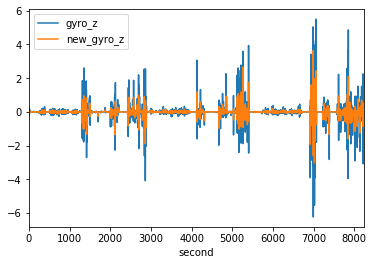

In [21]:
driving_event_detection.data.plot.line(x="second", y=["gyro_z", "new_gyro_z"])

#### Sliding Window
Sliding window with value of 3. Statistical features such as interquartile range of acceleration and gyro, average speed

In [22]:
import scipy.stats as stats

In [61]:
driving_event_detection.data[['new_acceleration_y', 'new_gyro_z']].rolling(3).var()

,new_acceleration_y,new_gyro_z
688080,NaN,NaN
1554664,NaN,NaN
1038426,0.002460,1.981964e-03
746317,0.004736,3.674323e-03
77421,0.033243,2.060156e-03
992307,0.029579,7.202763e-04
400858,0.059087,1.120934e-04
624754,0.265058,2.622353e-04
1336458,0.145206,6.760042e-04
300509,0.019962,8.296135e-04


In [23]:
stats_features = {}
# stats_features['acceleration_y_window_mean'] = driving_event_detection.data['new_acceleration_y'].rolling(3).mean()
stats_features['acceleration_y_variance'] = driving_event_detection.data['new_acceleration_y'].rolling(3).var()
# stats_features['acceleration_y_std'] = driving_event_detection.data['new_acceleration_y'].rolling(3).std()

# stats_features['gyro_z_window_mean'] = driving_event_detection.data['new_gyro_z'].rolling(3).mean()
stats_features['gyro_z_window_variance'] = driving_event_detection.data['new_gyro_z'].rolling(3).var()
# stats_features['gyro_z_window_std'] = driving_event_detection.data['new_gyro_z'].rolling(3).std()

In [24]:
train_data = pd.DataFrame.from_dict(stats_features).reset_index(drop=True)

In [25]:
train_data = train_data.dropna()

In [26]:
train_data.describe()

,acceleration_y_variance,gyro_z_window_variance
count,7.559000e+03,7.559000e+03
mean,2.274473e-01,1.647028e-02
std,1.168287e+00,1.155255e-01
min,2.183953e-09,1.598186e-11
25%,1.591419e-04,1.219863e-06
50%,4.293275e-03,9.099720e-05
75%,4.013759e-02,9.374399e-04
max,2.235289e+01,4.561377e+00


#### Clustering
4 clusters

In [27]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [28]:
from mpl_toolkits import mplot3d

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

In [30]:
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)

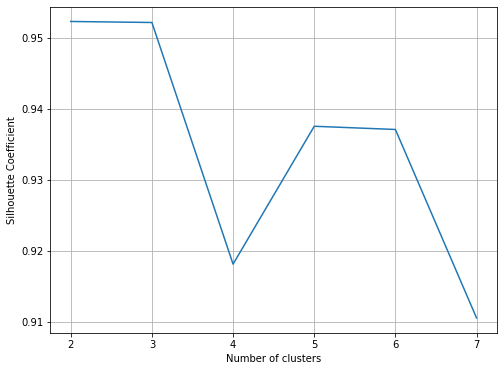

In [31]:
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics

plt.figure(figsize=(8,6))
k_range = range(2, 8)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1, tol=1e-8, max_iter=1000)
    km.fit(train_data)
    scores.append(metrics.silhouette_score(train_data, km.labels_))
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

In [33]:
km = KMeans(n_clusters=3, random_state=1, tol=1e-8)

In [34]:
km.fit(train_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=1e-08, verbose=0)

In [35]:
km.score(train_data)

-5024.126022285861

In [36]:
from matplotlib.pyplot import figure

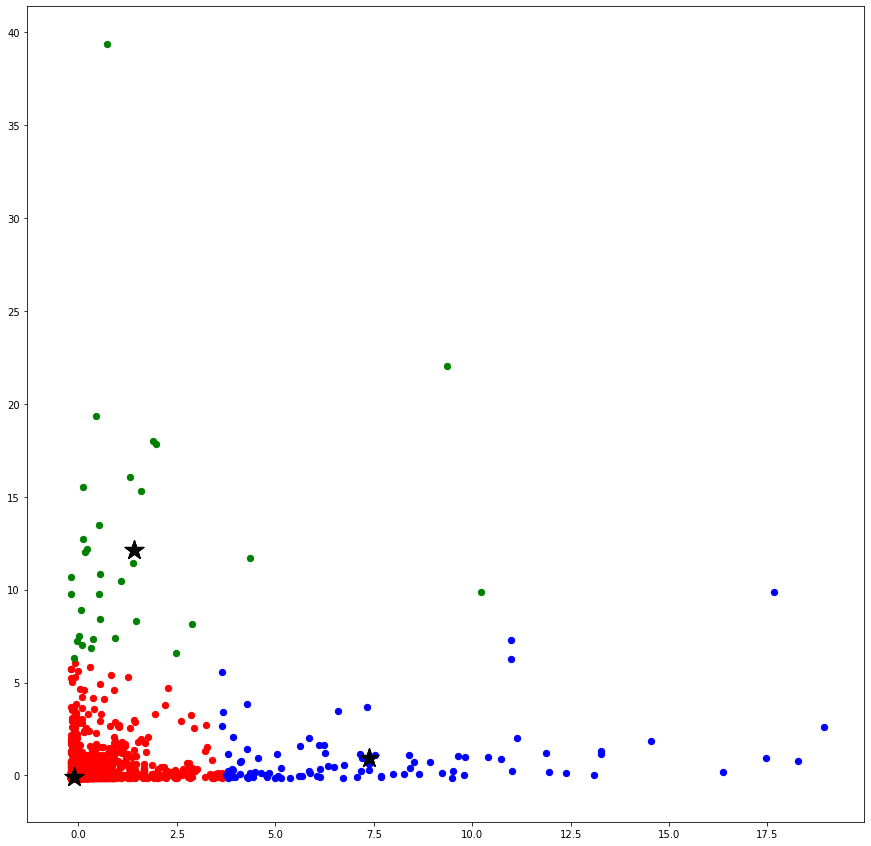

In [38]:
colors = ['r', 'g', 'b']
figure(figsize=(15,15))
k=3
x_arr = train_data
labels = km.labels_
centroids = km.cluster_centers_
for i in range(k):
    points = np.array([x_arr[j] for j in range(len(train_data)) if labels[j] == i])
    plt.scatter(points[:, 0], points[:, 1], s=40, c=colors[i])
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=400,
c='#050505')
plt.show()

In [39]:
km.cluster_centers_

array([[-0.09946542, -0.06426207],
       [ 1.41730849, 12.14170787],
       [ 7.38268757,  0.94814125]])

## Dangerous Driving Detection
The clustering model will be used to count any events that occured during the trip. These numbers of events will be fed to the supervised learning algorithm to detect if the trip was dangerous or not

In [44]:
def kalman_filter(data, columns):
    data = data.copy()
    for column in columns:
        kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
        measurement = data[column]
        mean, variance = kf.em(measurement).smooth(measurement)
        new_column_name = 'new_{}'.format(column)
        data[new_column_name] = mean
    return data

In [45]:
grouped_data = all_features.groupby("bookingID")

In [46]:
train_features = {'bookingID': [], 'num_of_detected_0': [], 'num_of_detected_1': [], 
                  'num_of_detected_2': [],
#                   'num_of_detected_3': [], 'num_of_detected_4': [], 
#                   'average_speed': []
                 }
for name, group in grouped_data:
    stats_features = {}
    stats_features['acceleration_y_variance'] = group['acceleration_y'].rolling(3).var()

    stats_features['gyro_z_window_variance'] = group['gyro_z'].rolling(3).var()
    
    cluster_data = pd.DataFrame.from_dict(stats_features)
    cluster_data = cluster_data.dropna()
    ss = StandardScaler()
    cluster_data = ss.fit_transform(cluster_data)
    predicted_events = km.predict(cluster_data)
    unique, counts = np.unique(predicted_events, return_counts=True)
    unique_counts = dict(zip(unique, counts))
    for i in range(3):
        if i not in unique_counts:
            unique_counts[i] = 0
    train_features['bookingID'].append(name)
    train_features['num_of_detected_0'].append(unique_counts[0])
    train_features['num_of_detected_1'].append(unique_counts[1])
    train_features['num_of_detected_2'].append(unique_counts[2])

In [47]:
train_df = pd.DataFrame.from_dict(train_features)

In [48]:
len(train_df['bookingID'].unique())

20000

In [49]:
train_df = train_df.merge(label, on="bookingID")

In [50]:
train_df = train_df.drop("bookingID", axis=1)

In [51]:
train_df.describe()

,num_of_detected_0,num_of_detected_1,num_of_detected_2,label
count,20018.000000,20018.000000,20018.000000,20018.000000
mean,790.406484,3.649765,10.938355,0.249825
std,426.158670,2.549245,6.309878,0.432923
min,113.000000,0.000000,0.000000,0.000000
25%,465.000000,2.000000,6.000000,0.000000
50%,730.000000,3.000000,10.000000,0.000000
75%,1061.000000,5.000000,15.000000,0.000000
max,7450.000000,46.000000,63.000000,1.000000


In [52]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
classifiers = {
    'kn': KNeighborsClassifier(3),
    'svc1': SVC(kernel="linear", C=0.025),
    'svc2': SVC(gamma=2, C=1),
    'tree': DecisionTreeClassifier(max_depth=5),
    'rf': RandomForestClassifier(max_depth=5, n_estimators=10),
    'mlp': MLPClassifier(alpha=1, max_iter=1000),
    'ada': AdaBoostClassifier(),
    'naive': GaussianNB(),
    'quadratic': QuadraticDiscriminantAnalysis(),
    'lr': LogisticRegression()
}

In [55]:
y = train_df['label']
x = train_df.drop('label', axis=1)

In [56]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [57]:
from sklearn.preprocessing import StandardScaler, MinMaxScalerxScaler

In [58]:
mms = StandardScaler()

In [59]:
x_train = mms.fit_transform(x_train)
x_test = mms.fit_transform(x_test)

In [60]:
for c in classifiers:
    model = classifiers[c]
    model.fit(x_train, y_train)
    print(c, model.score(x_test, y_test))

kn 0.691974691974692
svc1 0.7525807525807526
svc2 0.7644022644022644
tree 0.7617382617382618
rf 0.7639027639027639
mlp 0.7652347652347652
ada 0.7640692640692641
naive 0.7335997335997336
quadratic 0.7455877455877455
lr 0.7640692640692641


d:\belajar\aiforsea\env\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
